# Task 2: Exploratory Data Analysis


## Import packages

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score,precision_recall_curve
from sklearn.metrics import roc_curve,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split
%matplotlib inline
sns.set(color_codes=True)
np.random.seed(42)

---

## Loading data with Pandas

We need to load `client_data.csv` and `price_data.csv` into individual dataframes so that we can work with them in Python. For this notebook and all further notebooks, it will be assumed that the CSV files will the placed in the same file location as the notebook. If they are not, please adjust the directory within the `read_csv` method accordingly.

In [2]:
client_df = pd.read_csv('./client_data.csv')
price_df = pd.read_csv('./price_data.csv')

You can view the first 3 rows of a dataframe using the `head` method. Similarly, if you wanted to see the last 3, you can use `tail(3)`

In [3]:
client_df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,f,0.0,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0


In [4]:
price_df.head(3)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0


---

## Descriptive statistics of data

### Data types

It is useful to first understand the data that you're dealing with along with the data types of each column. The data types may dictate how you transform and engineer features.

To get an overview of the data types within a data frame, use the `info()` method.

In [5]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14606 non-null  object 
 1   channel_sales                   14606 non-null  object 
 2   cons_12m                        14606 non-null  int64  
 3   cons_gas_12m                    14606 non-null  int64  
 4   cons_last_month                 14606 non-null  int64  
 5   date_activ                      14606 non-null  object 
 6   date_end                        14606 non-null  object 
 7   date_modif_prod                 14606 non-null  object 
 8   date_renewal                    14606 non-null  object 
 9   forecast_cons_12m               14606 non-null  float64
 10  forecast_cons_year              14606 non-null  int64  
 11  forecast_discount_energy        14606 non-null  float64
 12  forecast_meter_rent_12m         

In [6]:
for date in ['date_activ','date_end','date_modif_prod','date_renewal']:
    client_df[date] = pd.to_datetime(client_df[date])

In [7]:
client_df['start_year'] = client_df['date_activ'].dt.year 
client_df['end_year'] = client_df['date_end'].dt.year 

In [8]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  193002 non-null  object 
 1   price_date          193002 non-null  object 
 2   price_off_peak_var  193002 non-null  float64
 3   price_peak_var      193002 non-null  float64
 4   price_mid_peak_var  193002 non-null  float64
 5   price_off_peak_fix  193002 non-null  float64
 6   price_peak_fix      193002 non-null  float64
 7   price_mid_peak_fix  193002 non-null  float64
dtypes: float64(6), object(2)
memory usage: 11.8+ MB


### Statistics

Now let's look at some statistics about the datasets. We can do this by using the `describe()` method.

In [9]:
client_df.describe()

,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,...,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn,start_year,end_year
count,1.460600e+04,1.460600e+04,14606.000000,14606,14606,14606,14606,14606.000000,14606.000000,14606.000000,...,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,2011-01-28 07:54:18.879912448,2016-07-27 20:48:26.422018560,2013-01-02 12:29:10.951663872,2015-07-21 06:59:00.353279488,1868.614880,1399.762906,0.966726,...,152.786896,24.565121,24.562517,1.292346,189.264522,4.997809,18.135136,0.097152,2010.577502,2016.064563
min,0.000000e+00,0.000000e+00,0.000000,2003-05-09 00:00:00,2016-01-28 00:00:00,2003-05-09 00:00:00,2013-06-26 00:00:00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.300000,0.000000,2003.000000,2016.000000
25%,5.674750e+03,0.000000e+00,0.000000,2010-01-15 00:00:00,2016-04-27 06:00:00,2010-08-12 00:00:00,2015-04-17 00:00:00,494.995000,0.000000,0.000000,...,0.000000,14.280000,14.280000,1.000000,50.712500,4.000000,12.500000,0.000000,2010.000000,2016.000000
50%,1.411550e+04,0.000000e+00,792.500000,2011-03-04 00:00:00,2016-08-01 00:00:00,2013-06-19 00:00:00,2015-07-27 00:00:00,1112.875000,314.000000,0.000000,...,37.395000,21.640000,21.640000,1.000000,112.530000,5.000000,13.856000,0.000000,2011.000000,2016.000000
75%,4.076375e+04,0.000000e+00,3383.000000,2012-04-19 00:00:00,2016-10-31 00:00:00,2015-06-16 00:00:00,2015-10-29 00:00:00,2401.790000,1745.750000,0.000000,...,193.980000,29.880000,29.880000,1.000000,243.097500,6.000000,19.172500,0.000000,2012.000000,2016.000000
max,6.207104e+06,4.154590e+06,771203.000000,2014-09-01 00:00:00,2017-06-13 00:00:00,2016-01-29 00:00:00,2016-01-28 00:00:00,82902.830000,175375.000000,30.000000,...,15042.790000,374.640000,374.640000,32.000000,24570.650000,13.000000,320.000000,1.000000,2014.000000,2017.000000
std,5.734653e+05,1.629731e+05,64364.196422,NaN,NaN,NaN,NaN,2387.571531,3247.786255,5.108289,...,341.369366,20.231172,20.230280,0.709774,311.798130,1.611749,13.534743,0.296175,1.653268,0.245761


In [10]:
client_df.describe(include=['O'])

,id,channel_sales,has_gas,origin_up
count,14606,14606,14606,14606
unique,14606,8,2,6
top,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,f,lxidpiddsbxsbosboudacockeimpuepw
freq,1,6754,11955,7097


In [11]:
price_df.describe()

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
std,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


### Duplicates and null values

Now let's look if there are duplicates or null values in the datasets. We can do this by using the `duplicated()` method.

In [12]:
def duplicate_null(dataset,dataset_name):
    print(f'The {dataset_name} contains {dataset.shape[0]} rows, {dataset.shape[1]} columns, {dataset.duplicated().sum()} duplicated rows, and {dataset.isna().sum().sum()} null values. ')

In [13]:
duplicate_null(client_df,'client_df')
print('-------------------------------------------------------------------------------------------------------')
duplicate_null(price_df,'price_df')

The client_df contains 14606 rows, 28 columns, 0 duplicated rows, and 0 null values. 
-------------------------------------------------------------------------------------------------------
The price_df contains 193002 rows, 8 columns, 0 duplicated rows, and 0 null values. 


---
# Sub-Task 1
## Data visualization

In [14]:
def bar_plot_prec_above(dataset,feature,perc_x_shift,figsize_,):
    plt.figure(figsize=figsize_)
    ax = sns.barplot(x=dataset[feature].value_counts().index,
                     y=(dataset[feature].value_counts() / dataset[feature].count()) * 100,
                     edgecolor='k',order=dataset[feature].value_counts().index)
    bars_height = [bar.get_height().round(2) for bar in ax.patches]
    bars_width = [bar.get_width() / 2 for bar in ax.patches]
    plt.yticks([x for x in range(0, 110, 10)])
    for i in range(len(bars_height)):
        plt.text(x=i-perc_x_shift, y=bars_height[i] + 0.5, s=f'{bars_height[i]}%')
    if len(dataset[feature].value_counts()) > 1:
        return ax
    else:
        return None
    plt.show()

In [15]:
def barchart_stacked_perc(df,x,hue,figsize_,title_,rot_,xlabel_,ylabel_,legend_fontsize,annot_fontsize,xticklabels=None):
    plot_data = df.groupby(x)[hue].value_counts(normalize=True).mul(100).rename('perc').reset_index()
    plot_data = plot_data.pivot(columns='churn',index=x,values='perc').fillna(0)
    ax = plot_data.plot(kind='bar',figsize=figsize_,rot=rot_,stacked=True,edgecolor='k')
    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
        x,y = p.get_xy()
        if height >= 0.1:
                plt.annotate(f'{height.round(1)}%',xy=(x + width/2, y + height/2),ha='center',va='center',size=annot_fontsize)
    plt.legend(['Retention','Churn'],loc='best',fontsize=legend_fontsize)
    modified_xlabel = x.astype(str)
    plt.xlabel(xlabel_)
    plt.ylabel(ylabel_)
    plt.title(title_)
    if xticklabels:
        ax.set_xticks(range(len(xticklabels)))
        ax.set_xticklabels(xticklabels)
    plt.show()

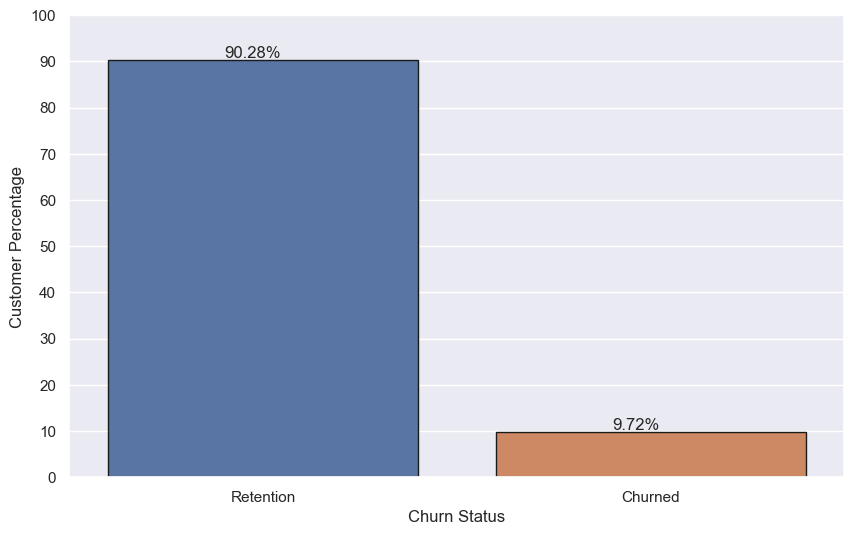

In [16]:
ax = bar_plot_prec_above(client_df, 'churn',0.1,(10,6))
ax.set_xticks([0, 1], ['Retention', 'Churned'])
ax.set_xlabel('Churn Status')
ax.set_ylabel('Customer Percentage')
plt.show()

Only 9.72% (1420 client) of the company's clients churned which shows a high confidence and satisfaction of company's service.

In [17]:
LE = LabelEncoder()
LE.fit(client_df['channel_sales'])
client_df['channel_sales'] = LE.transform(client_df['channel_sales'])
LE.classes_

array(['MISSING', 'epumfxlbckeskwekxbiuasklxalciiuu',
       'ewpakwlliwisiwduibdlfmalxowmwpci',
       'fixdbufsefwooaasfcxdxadsiekoceaa',
       'foosdfpfkusacimwkcsosbicdxkicaua',
       'lmkebamcaaclubfxadlmueccxoimlema',
       'sddiedcslfslkckwlfkdpoeeailfpeds',
       'usilxuppasemubllopkaafesmlibmsdf'], dtype=object)

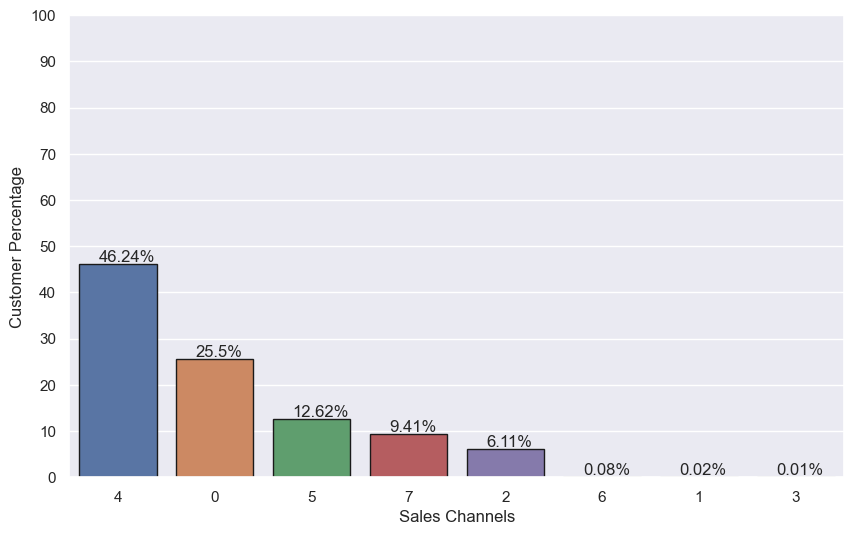

In [18]:
ax = bar_plot_prec_above(client_df, 'channel_sales',0.2,(10,6))
ax.set_xlabel('Sales Channels')
ax.set_ylabel('Customer Percentage')
plt.show()

The most used sales channel is channel 4 with more than 46% of clients contacted by this channel, while the least used ones are channels 6, 1, and 3 which suggests that those channel are no good. 

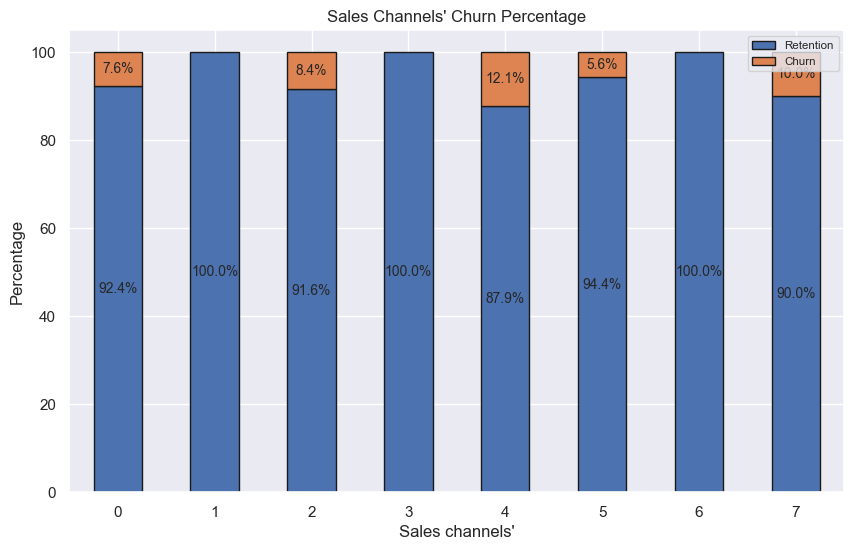

In [19]:
barchart_stacked_perc(client_df,'channel_sales','churn',(10,6),"Sales Channels' Churn Percentage",0,"Sales channels'","Percentage",'x-small',10)

The clients contacted using channel 4 have the most churn percentage with 12.1% followed by channel 7, 2, 0, and 5 which is kind of reasonable as the biggest segment of the customers are also contacted with those channels, but focusing on channel 0 which have a acceptable churn percentage given that the second biggest client segments were contacted by this channel.

In [20]:
LE.fit(client_df['origin_up'])
client_df['origin_up'] = LE.transform(client_df['origin_up'])
LE.classes_

array(['MISSING', 'ewxeelcelemmiwuafmddpobolfuxioce',
       'kamkkxfxxuwbdslkwifmmcsiusiuosws',
       'ldkssxwpmemidmecebumciepifcamkci',
       'lxidpiddsbxsbosboudacockeimpuepw',
       'usapbepcfoloekilkwsdiboslwaxobdp'], dtype=object)

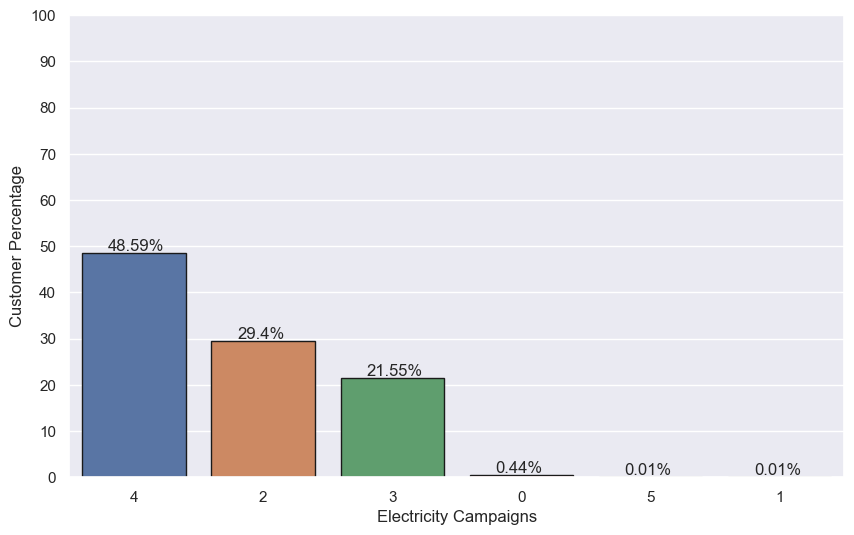

In [21]:
ax = bar_plot_prec_above(client_df, 'origin_up',0.2,(10,6))
ax.set_xlabel('Electricity Campaigns')
ax.set_ylabel('Customer Percentage')
plt.show()

The biggest segment of company's clients joined the company as a result of campaign 4 with a significant segments joined as result of campaigns 2 and 3, while campaigns 0,5,1 appears to be failed campaigns, this shows the path that the company should take in the next campaigns to get more clients.

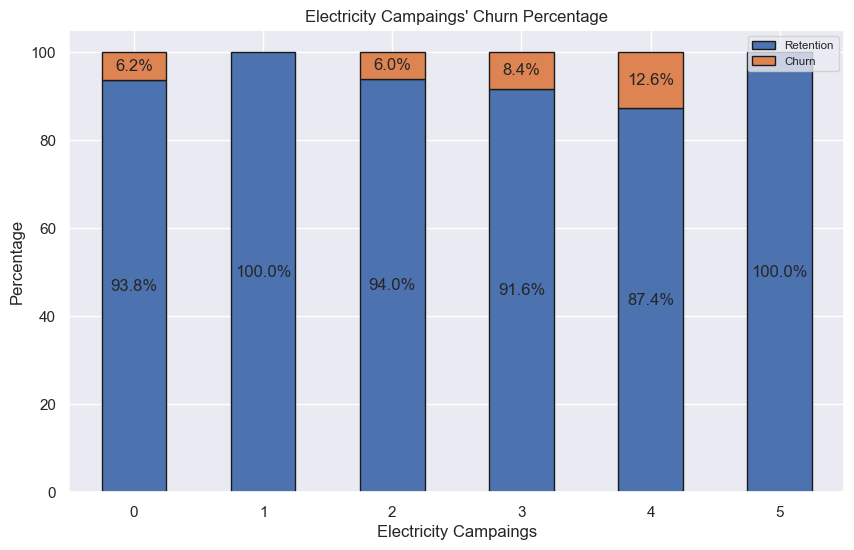

In [22]:
barchart_stacked_perc(client_df,'origin_up','churn',(10,6),"Electricity Campaings' Churn Percentage",0,'Electricity Campaings',"Percentage",'x-small',12)

The churn percentages of customers based on which campaign they joined on is reasonable with respect to size of customers who joined in every campaign, but also the company must pay attention to churning reasons, to ensure that it doesn't related to the fulfillment of the campaign promises.

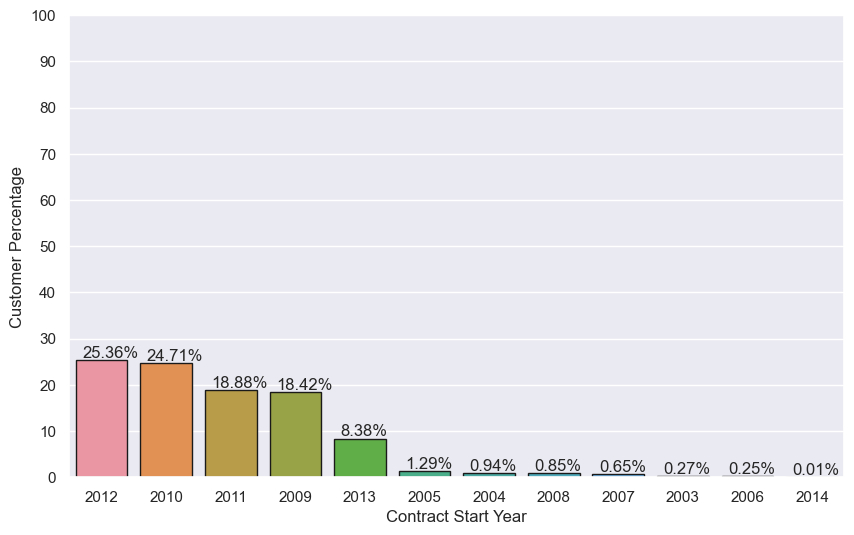

In [23]:
ax = bar_plot_prec_above(client_df,'start_year',0.3,(10,6))
ax.set_xlabel('Contract Start Year')
ax.set_ylabel('Customer Percentage')
plt.show()

Most of company's clients starts their contract between 2009 and 2013 with a very low percentage of clients have contract since before 2009 or after 2013.

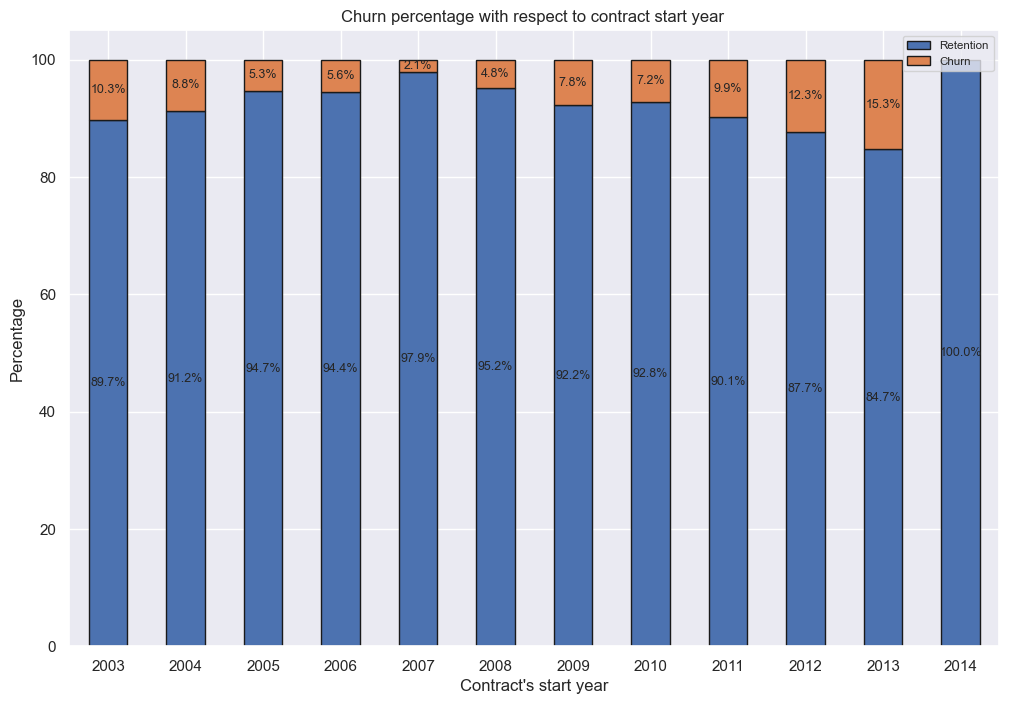

In [24]:
barchart_stacked_perc(client_df,'start_year','churn',(12,8),"Churn percentage with respect to contract start year ",0,
                      "Contract's start year","Percentage",'x-small',9)

Newer contract holders have fairly higher churning percentage.

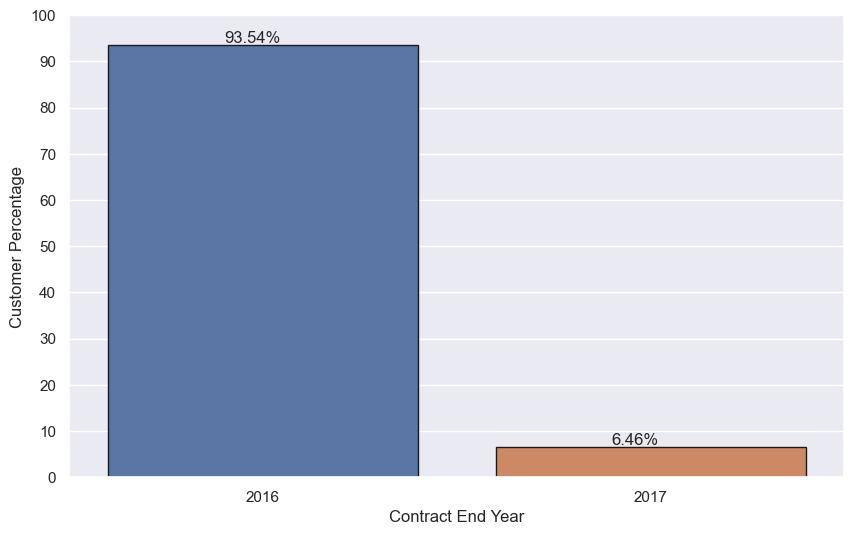

In [25]:
ax = bar_plot_prec_above(client_df,'end_year',0.1,(10,6))
ax.set_xlabel('Contract End Year')
ax.set_ylabel('Customer Percentage')
plt.show()

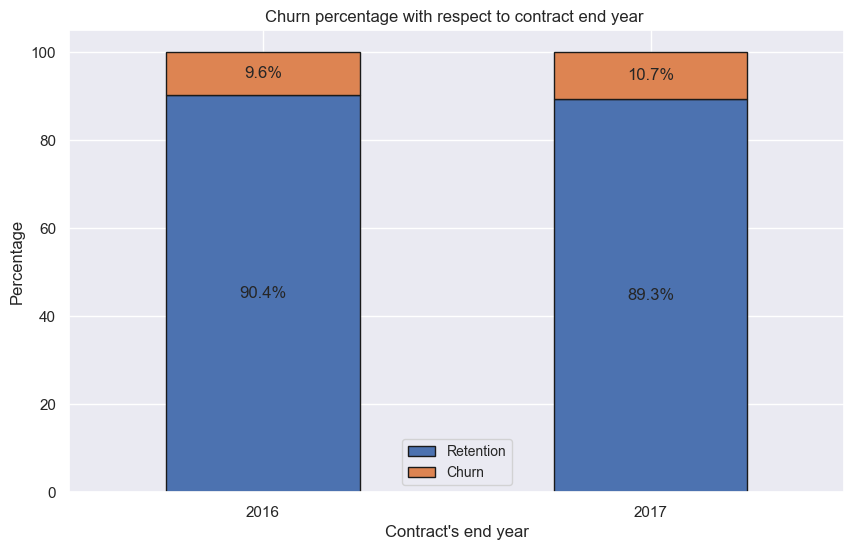

In [26]:
barchart_stacked_perc(client_df,'end_year','churn',(10,6),"Churn percentage with respect to contract end year ",0,
                      "Contract's end year","Percentage",'small',12)

Most of the clients' contacts will end in 2016, while the churn percentage depending on contract's end year is equally so the contract end year doesn't affect churning of customers. 

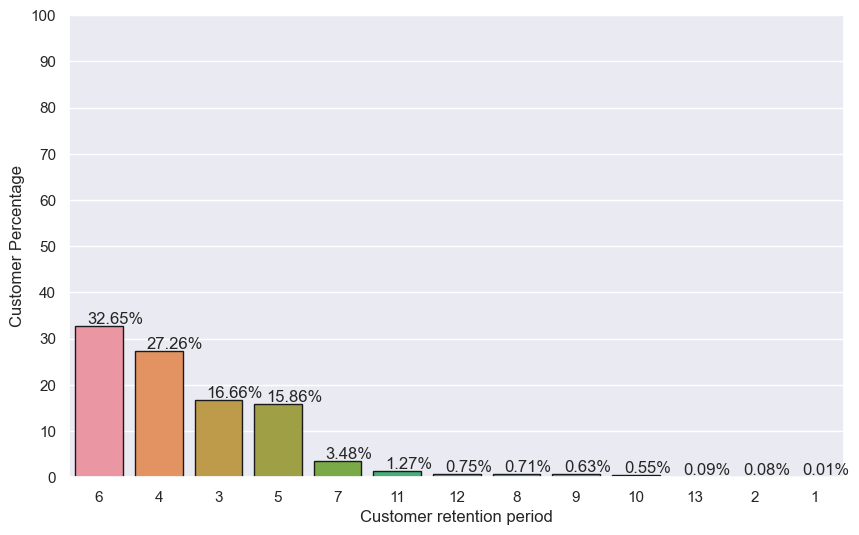

In [27]:
ax = bar_plot_prec_above(client_df,'num_years_antig',0.2,(10,6))
ax.set_xlabel('Customer retention period')
ax.set_ylabel('Customer Percentage')
plt.show()

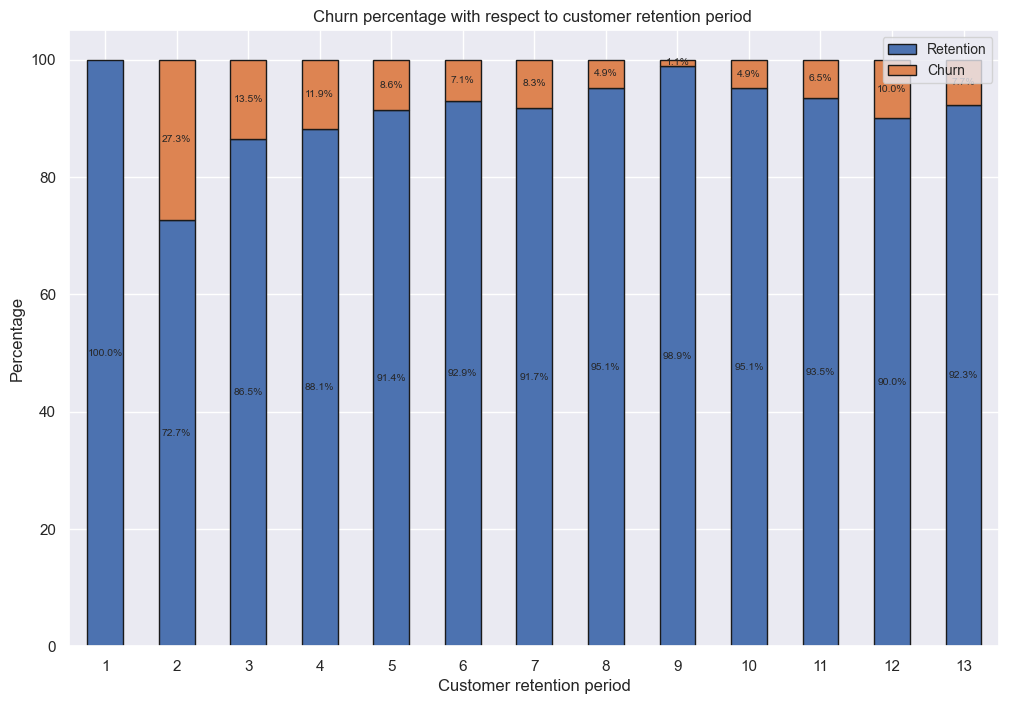

In [28]:
barchart_stacked_perc(client_df,'num_years_antig','churn',(12,8),"Churn percentage with respect to customer retention period ",0,
                      "Customer retention period","Percentage",'small',7.5)

Most clients have retention period between 3 to 6 years, with newer clients have tendency to churn more than the old ones. 

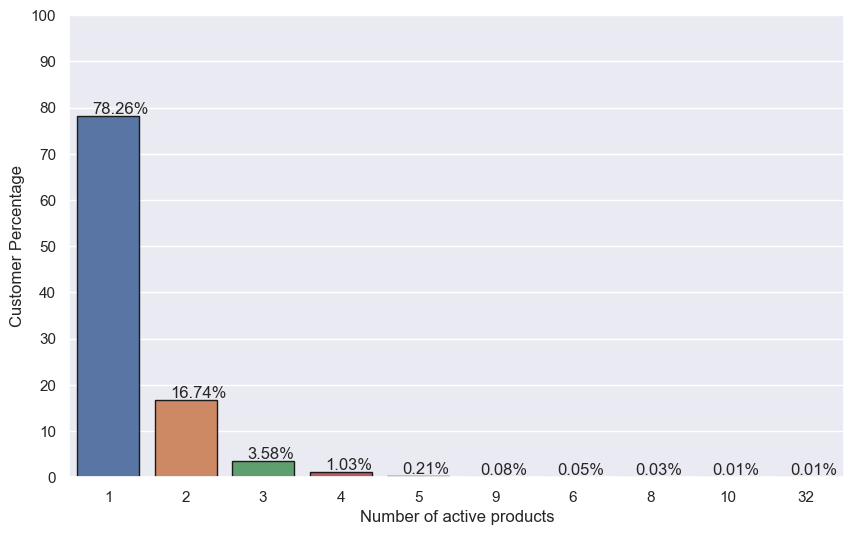

In [29]:
ax = bar_plot_prec_above(client_df,'nb_prod_act',0.2,(10,6))
ax.set_xlabel('Number of active products')
ax.set_ylabel('Customer Percentage')
plt.show()

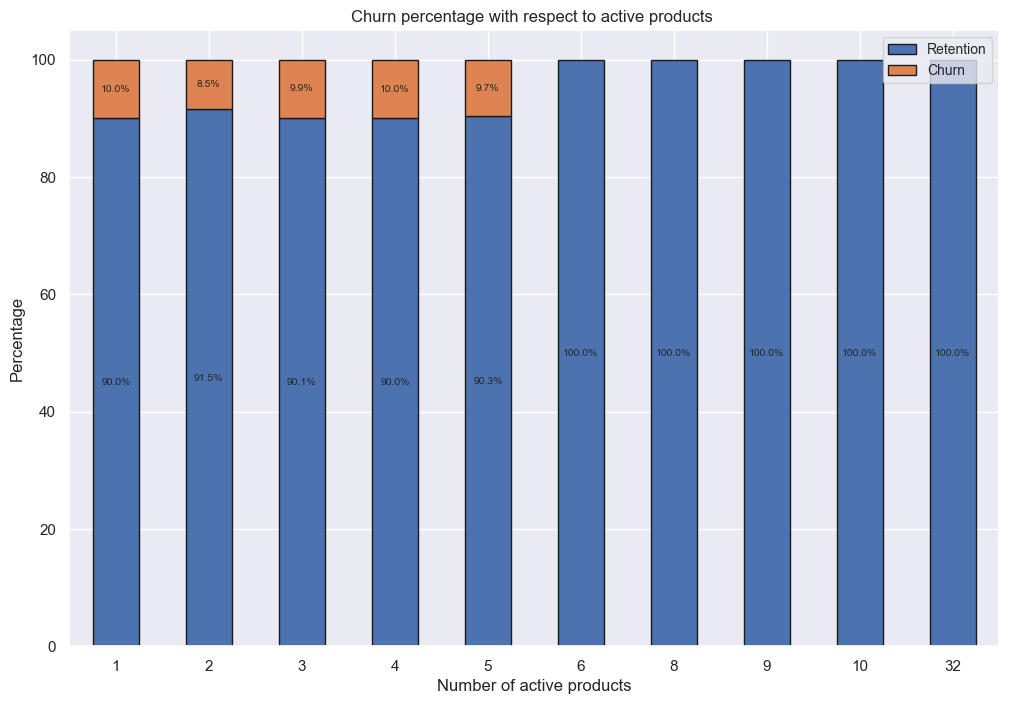

In [30]:
barchart_stacked_perc(client_df,'nb_prod_act','churn',(12,8),"Churn percentage with respect to active products ",0,
                      "Number of active products","Percentage",'small',7.5)

Majority of the clients have only one active company's product (78%) with a significant proportion have two active company's product (16%) and smaller proportions have more than two active products, Also churning percentage is almost equal for clients have one - five active products, with almost zero churning percent for clients have more than five active products.

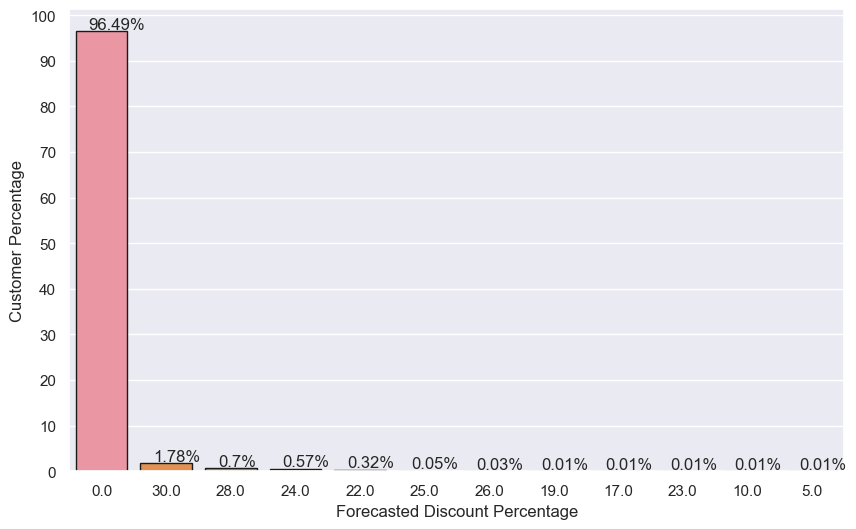

In [31]:
ax = bar_plot_prec_above(client_df,'forecast_discount_energy',0.2,(10,6))
ax.set_xlabel('Forecasted Discount Percentage')
ax.set_ylabel('Customer Percentage')
plt.show()

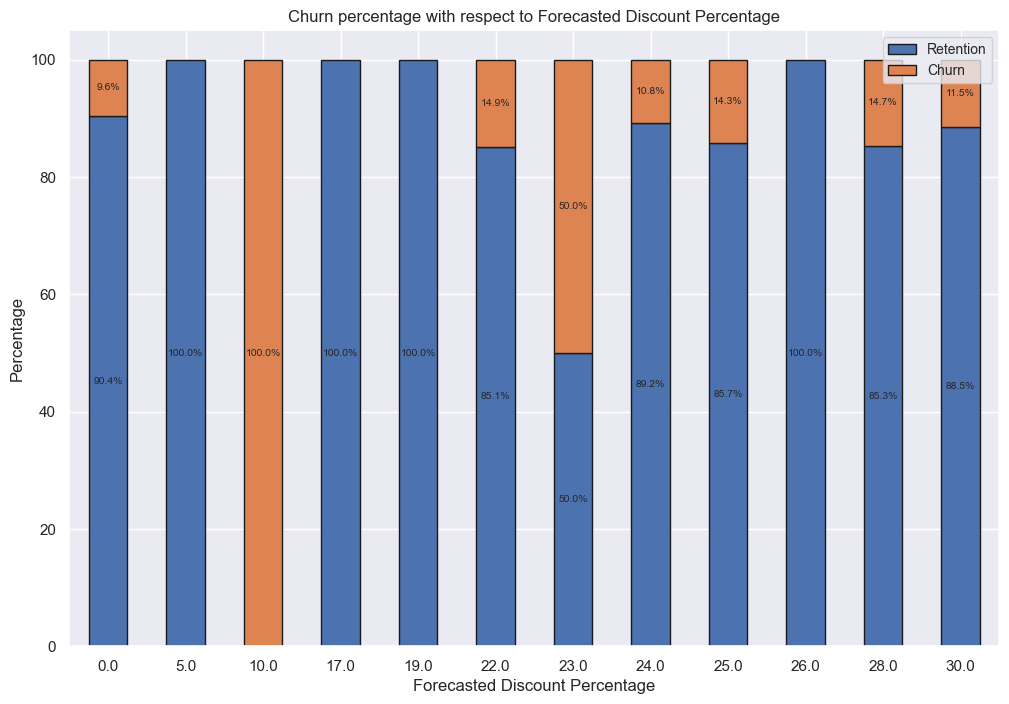

In [32]:
barchart_stacked_perc(client_df,'forecast_discount_energy','churn',(12,8),"Churn percentage with respect to Forecasted Discount Percentage",0,
                      "Forecasted Discount Percentage","Percentage",'small',7.5)

Vast majority of the clients have zero percent forecasted discount.

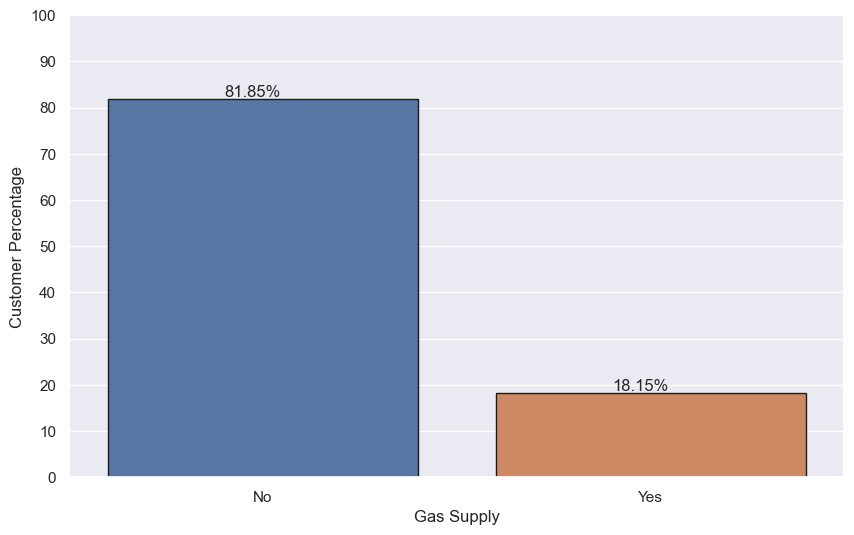

In [33]:
ax = bar_plot_prec_above(client_df,'has_gas',0.1,(10,6))
ax.set_xlabel('Gas Supply')
ax.set_xticks([0,1],['No','Yes'])
ax.set_ylabel('Customer Percentage')
plt.show()

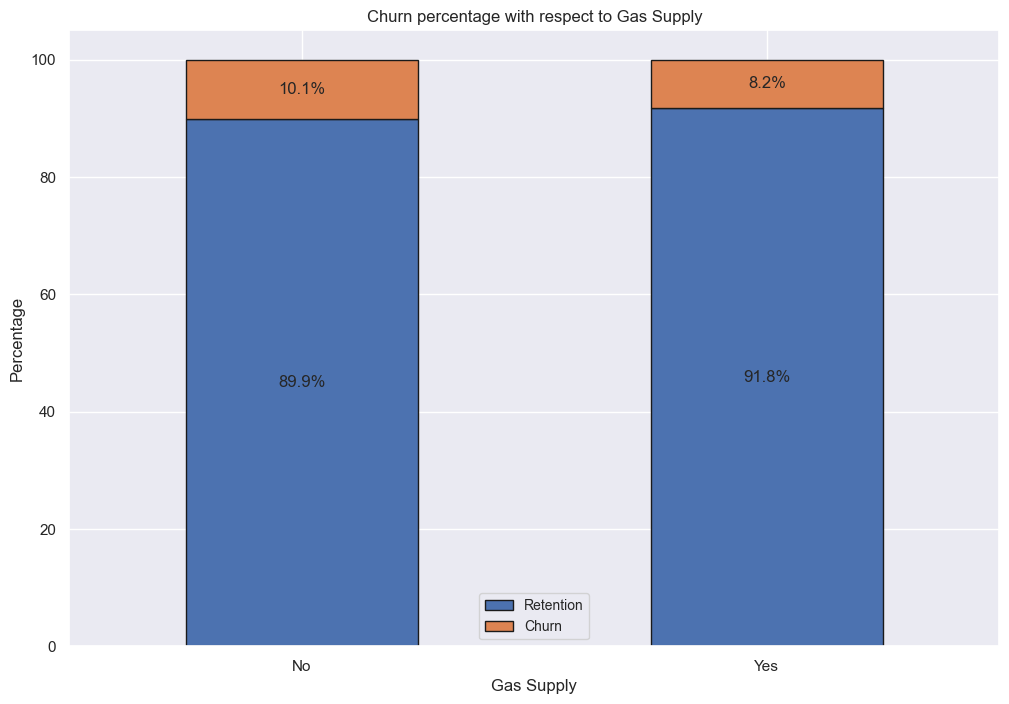

In [34]:
barchart_stacked_perc(client_df,'has_gas','churn',(12,8),"Churn percentage with respect to Gas Supply",0,
                      "Gas Supply","Percentage",'small',12,xticklabels=['No','Yes'])

Only 18.2% have gas and electricity, and clients who have electricity only are more likely to churn.

In [35]:
plt.style.use('default')

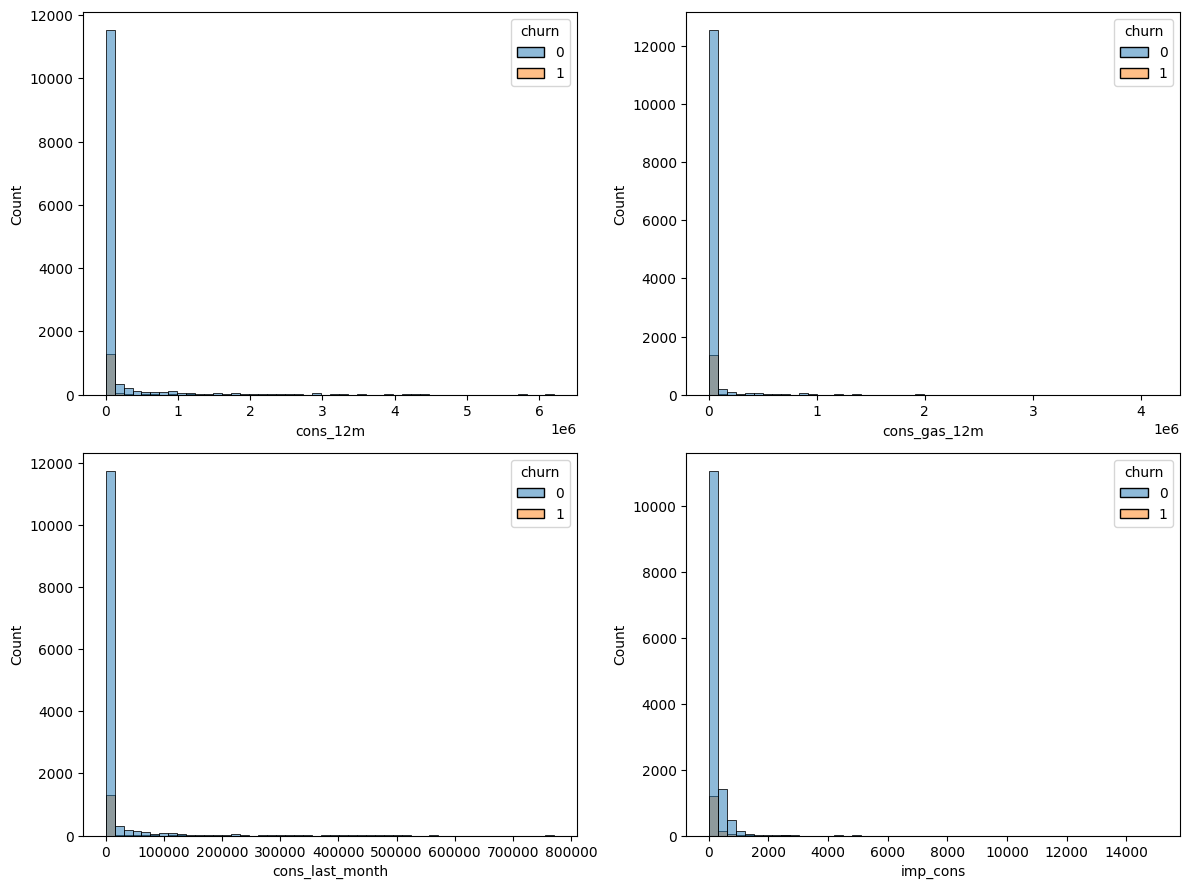

In [36]:
cons_cols = ['cons_12m', 'cons_gas_12m', 'cons_last_month','imp_cons']
fig, ax = plt.subplots(2,2,figsize=(12,9))
ax = ax.flatten()
for i in range(len(cons_cols)):
    sns.histplot(data=client_df,x=cons_cols[i],hue='churn',legend=True,bins=50,ax=ax[i])
plt.tight_layout()
plt.show()

Consumption features distribution have significantly high number of tails which seems to be outliers.

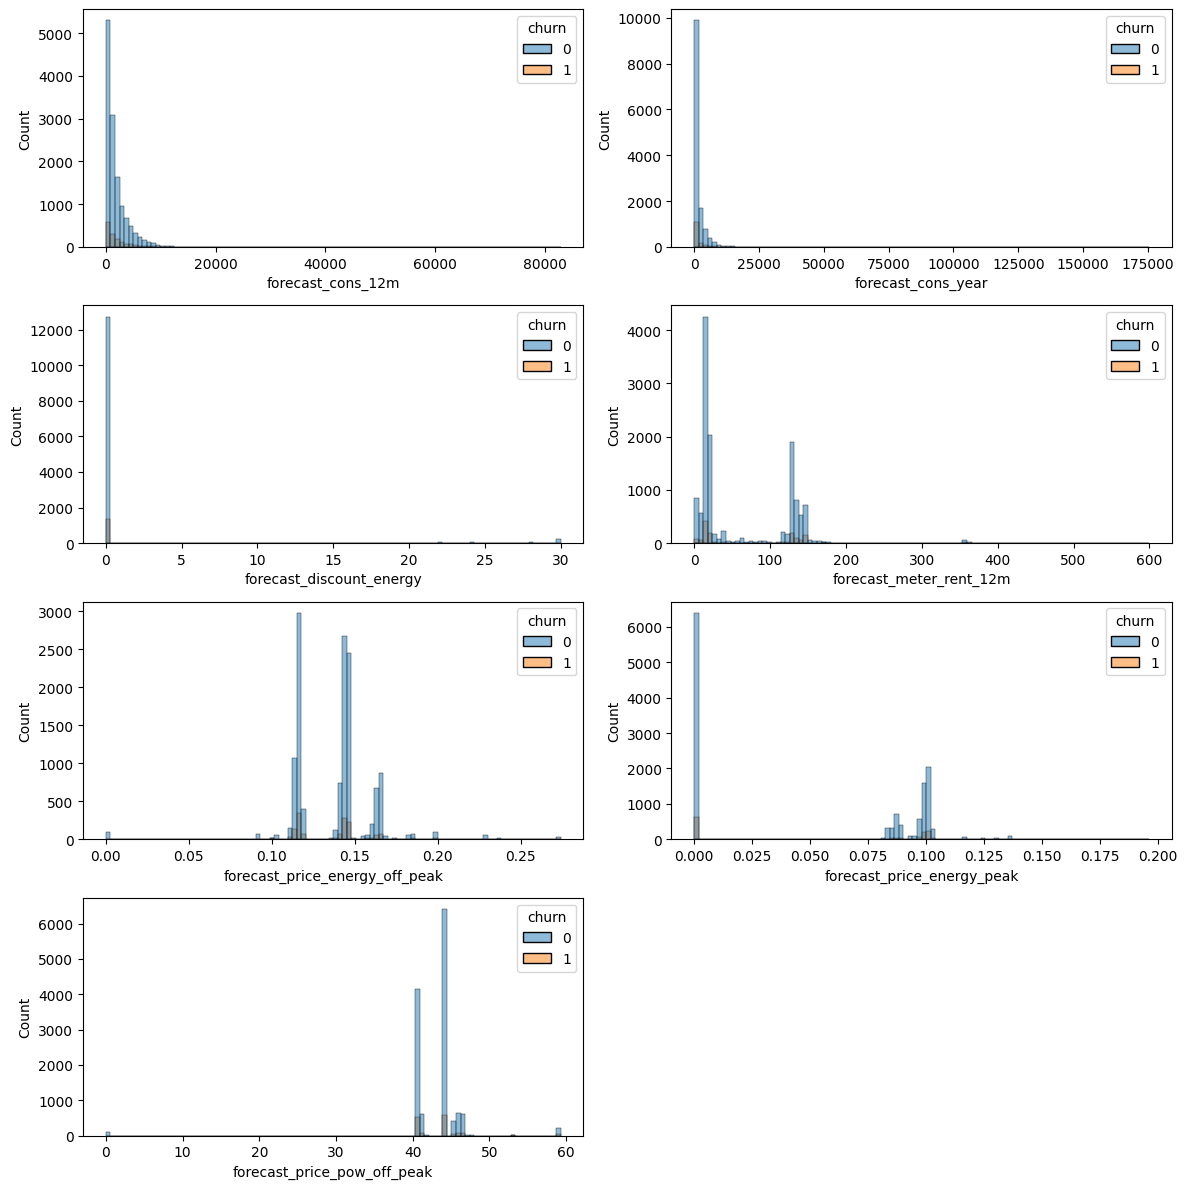

In [37]:
forecast_cols = ['forecast_cons_12m','forecast_cons_year','forecast_discount_energy','forecast_meter_rent_12m',
                 'forecast_price_energy_off_peak','forecast_price_energy_peak','forecast_price_pow_off_peak']
fig, ax = plt.subplots(4,2,figsize=(12,12))
ax = ax.flatten()
for i in range(len(forecast_cols)):
    sns.histplot(data=client_df,x=forecast_cols[i],hue='churn',legend=True,bins=100,ax=ax[i])
ax[-1].set_visible(False)
plt.tight_layout()
plt.show()

Forecasted prices features is roughly centered about some points with some skewness also.

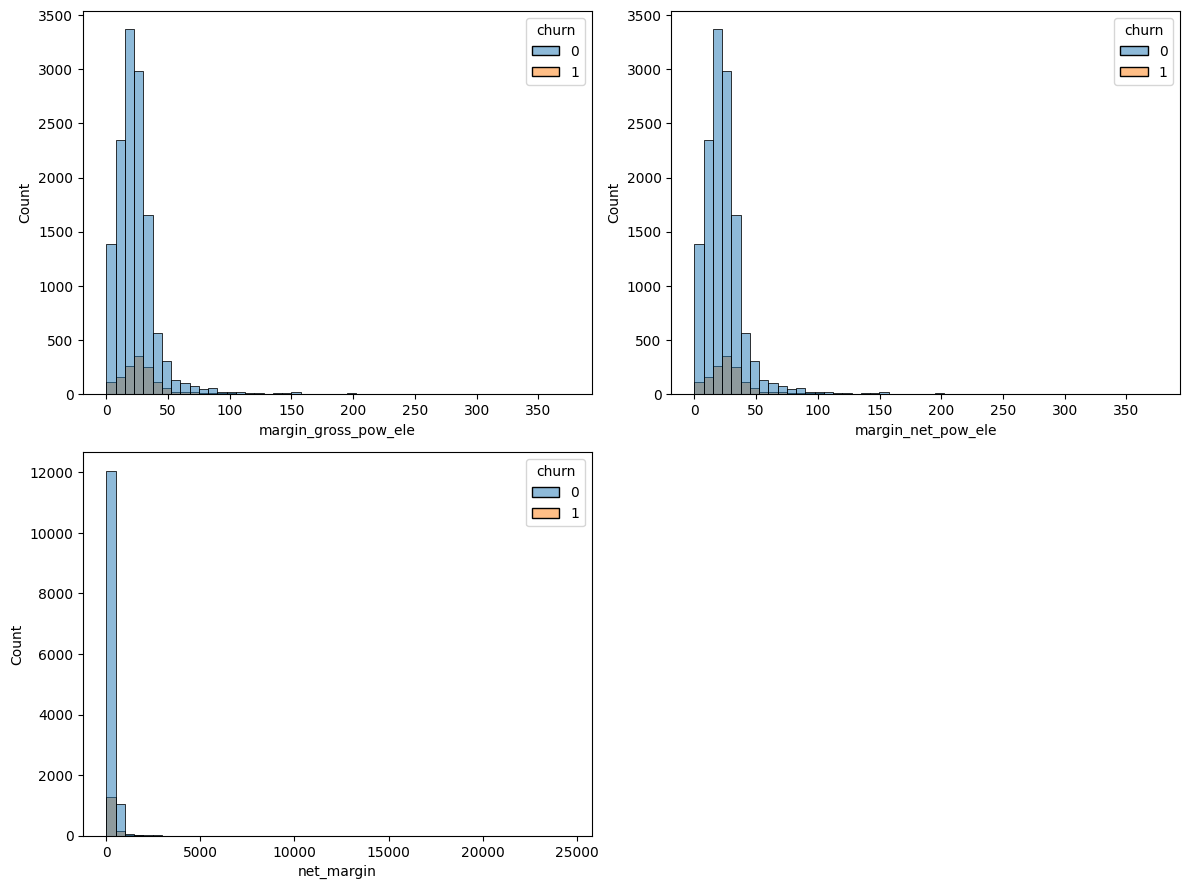

In [38]:
margin_cols = ['margin_gross_pow_ele', 'margin_net_pow_ele','net_margin']
fig, ax = plt.subplots(2,2,figsize=(12,9))
ax = ax.flatten()
for i in range(len(margin_cols)):
    sns.histplot(data=client_df,x=margin_cols[i],hue='churn',legend=True,bins=50,ax=ax[i])
ax[-1].set_visible(False)
plt.tight_layout()
plt.show()

Margins features are highly skewed.

In [39]:
price_df.columns

Index(['id', 'price_date', 'price_off_peak_var', 'price_peak_var',
       'price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix',
       'price_mid_peak_fix'],
      dtype='object')

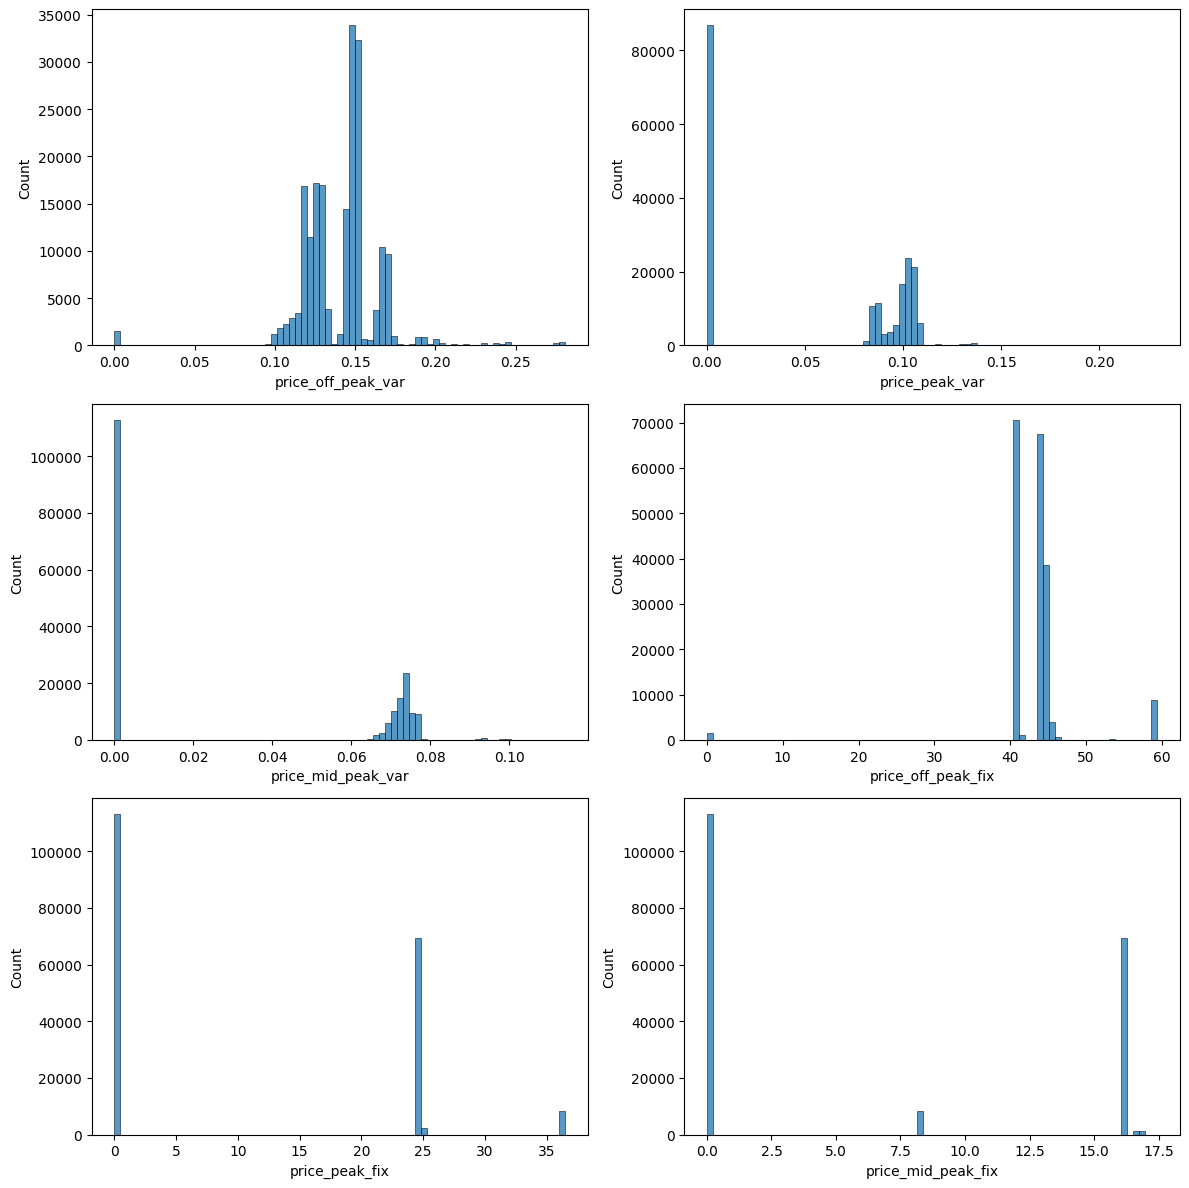

In [40]:
prices_cols = ['price_off_peak_var', 'price_peak_var','price_mid_peak_var', 'price_off_peak_fix', 'price_peak_fix','price_mid_peak_fix']
fig, ax = plt.subplots(3,2,figsize=(12,12))
ax = ax.flatten()
for i in range(len(prices_cols)):
    sns.histplot(data=price_df,x=prices_cols[i],bins=75,ax=ax[i])
plt.tight_layout()
plt.show()

The Distribuation of prices shows high count at 0 price for peak and mid-peak prices for either fixed or variable plan, with much more less for off-peak prices so I think it is more reasonable to continue the analysis using off-peak prices. 

---
# Sub-Task 2
## Price sensitivity

In [41]:
df = price_df.drop(columns=['price_date'])
df = df.groupby(['id']).agg(['mean','max','min'])
df.head(2)

price_off_peak_var                      \
                                               mean       max       min   
id                                                                        
0002203ffbb812588b632b9e628cc38d           0.124338  0.128067  0.119906   
0004351ebdd665e6ee664792efc4fd13           0.146426  0.148405  0.143943   

                                 price_peak_var                      \
                                           mean       max       min   
id                                                                    
0002203ffbb812588b632b9e628cc38d       0.103794  0.105842  0.101673   
0004351ebdd665e6ee664792efc4fd13       0.000000  0.000000  0.000000   

                                 price_mid_peak_var                      \
                                               mean       max       min   
id                                                                        
0002203ffbb812588b632b9e628cc38d            0.07316  0.073773  0.070232   
0004351ebdd665e6ee664792efc4fd13            0.00000  0.000000  0.000000   

                                 price_off_peak_fix                        \
                                               mean        max        min   
id                                                                          
0002203ffbb812588b632b9e628cc38d          40.701732  40.728885  40.565969   
0004351ebdd665e6ee664792efc4fd13          44.385450  44.444710  44.266931   

                                 price_peak_fix                       \
                                           mean       max        min   
id                                                                     
0002203ffbb812588b632b9e628cc38d      24.421038  24.43733  24.339581   
0004351ebdd665e6ee664792efc4fd13       0.000000   0.00000   0.000000   

                                 price_mid_peak_fix                        
                                               mean        max        min  
id                                                                         
0002203ffbb812588b632b9e628cc38d          16.280694  16.291555  16.226389  
0004351ebdd665e6ee664792efc4fd13           0.000000   0.000000   0.000000

In [42]:
def rename_flatten_cols(df):
    temp = df.copy()
    temp.columns = df.columns.get_level_values(1)
    renamed_cols = []
    for i in range (len(df.columns.get_level_values(1))):
        renamed_cols.append(df.columns.get_level_values(0)[i]+'_'+df.columns.get_level_values(1)[i])
    temp.columns = renamed_cols
    return temp

In [43]:
df = rename_flatten_cols(df)
df.reset_index(inplace=True)

In [44]:
price_churn_df = df.merge(client_df[['id','churn']],on='id',how='left')
price_churn_df.head(2)

,id,price_off_peak_var_mean,price_off_peak_var_max,price_off_peak_var_min,price_peak_var_mean,price_peak_var_max,price_peak_var_min,price_mid_peak_var_mean,price_mid_peak_var_max,price_mid_peak_var_min,price_off_peak_fix_mean,price_off_peak_fix_max,price_off_peak_fix_min,price_peak_fix_mean,price_peak_fix_max,price_peak_fix_min,price_mid_peak_fix_mean,price_mid_peak_fix_max,price_mid_peak_fix_min,churn
0,0002203ffbb812588b632b9e628cc38d,0.124338,0.128067,0.119906,0.103794,0.105842,0.101673,0.07316,0.073773,0.070232,40.701732,40.728885,40.565969,24.421038,24.43733,24.339581,16.280694,16.291555,16.226389,0.0
1,0004351ebdd665e6ee664792efc4fd13,0.146426,0.148405,0.143943,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,44.385450,44.444710,44.266931,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0


In [45]:
price_churn_df.shape

(16096, 20)

In [46]:
price_churn_df.isna().sum()

id                            0
price_off_peak_var_mean       0
price_off_peak_var_max        0
price_off_peak_var_min        0
price_peak_var_mean           0
price_peak_var_max            0
price_peak_var_min            0
price_mid_peak_var_mean       0
price_mid_peak_var_max        0
price_mid_peak_var_min        0
price_off_peak_fix_mean       0
price_off_peak_fix_max        0
price_off_peak_fix_min        0
price_peak_fix_mean           0
price_peak_fix_max            0
price_peak_fix_min            0
price_mid_peak_fix_mean       0
price_mid_peak_fix_max        0
price_mid_peak_fix_min        0
churn                      1490
dtype: int64

In [47]:
price_churn_df.dropna(subset=['churn'],inplace=True)
price_churn_df.reset_index(drop=True,inplace=True)
price_churn_df.shape

(14606, 20)

In [48]:
temp2 = pd.DataFrame(price_df[price_df['id'].isin(price_churn_df['id'])])
temp2 = temp2.merge(price_churn_df,on='id',how='left')

In [49]:
temp2[temp2['price_date'] == '2015-12-01'].reset_index(drop=True)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_off_peak_var_mean,price_off_peak_var_max,...,price_off_peak_fix_mean,price_off_peak_fix_max,price_off_peak_fix_min,price_peak_fix_mean,price_peak_fix_max,price_peak_fix_min,price_mid_peak_fix_mean,price_mid_peak_fix_max,price_mid_peak_fix_min,churn
0,038af19179925da21a25619c5a24b745,2015-12-01,0.145859,0.000000,0.000000,44.444710,0.00000,0.000000,0.148550,0.151367,...,44.355820,44.444710,44.266930,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
1,31f2ce549924679a3cbb2d128ae9ea43,2015-12-01,0.118755,0.101071,0.075096,40.728885,24.43733,16.291555,0.123027,0.126916,...,40.661003,40.728885,40.565969,24.396601,24.43733,24.339581,16.264402,16.291555,16.226389,0.0
2,48f3e6e86f7a8656b2c6b6ce2763055e,2015-12-01,0.143943,0.000000,0.000000,44.444710,0.00000,0.000000,0.145552,0.148405,...,44.400265,44.444710,44.266931,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
3,7363a2ebfbb3148c8ef6d25323e4093a,2015-12-01,0.117594,0.099910,0.073935,40.728885,24.43733,16.291555,0.122945,0.127710,...,40.647427,40.728885,40.565969,24.388455,24.43733,24.339578,16.258971,16.291555,16.226383,1.0
4,ef716222bbd97a8bdfcbb831e3575560,2015-12-01,0.147600,0.000000,0.000000,44.444710,0.00000,0.000000,0.149411,0.152062,...,44.355820,44.444710,44.266930,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14599,cd622263c26436d1237e94ff05cdd506,2015-12-01,0.147600,0.000000,0.000000,44.444710,0.00000,0.000000,0.149913,0.152062,...,44.370635,44.444710,44.266930,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
14600,ed3434c3c1e2056d1a313e2671815e4d,2015-12-01,0.118353,0.101898,0.074321,40.728885,24.43733,16.291555,0.124506,0.128069,...,40.728885,40.728885,40.728885,24.437330,24.43733,24.437330,16.291555,16.291555,16.291555,0.0
14601,d00da2c0c568614b9937791f681cd7d7,2015-12-01,0.146788,0.000000,0.000000,44.444710,0.00000,0.000000,0.148871,0.151250,...,44.355820,44.444710,44.266930,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
14602,045f94f0b7f538a8d8fae11080abb5da,2015-12-01,0.144698,0.000000,0.000000,44.444710,0.00000,0.000000,0.147921,0.151367,...,44.355820,44.444710,44.266930,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0


In [50]:
offpeak_price_features = ['price_off_peak_var','price_off_peak_fix']
for feature in offpeak_price_features:
    temp2[f'diff_lastmonth_mean_{feature}'] = temp2[f'{feature}'] - temp2[f'{feature}_mean']
temp2.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_off_peak_var_mean,price_off_peak_var_max,...,price_off_peak_fix_min,price_peak_fix_mean,price_peak_fix_max,price_peak_fix_min,price_mid_peak_fix_mean,price_mid_peak_fix_max,price_mid_peak_fix_min,churn,diff_lastmonth_mean_price_off_peak_var,diff_lastmonth_mean_price_off_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.14855,0.151367,...,44.26693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002817,-0.088889
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.14855,0.151367,...,44.26693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002817,-0.088889
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.14855,0.151367,...,44.26693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002817,-0.088889
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0.14855,0.151367,...,44.26693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001076,-0.088889
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0.14855,0.151367,...,44.26693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001076,-0.088889


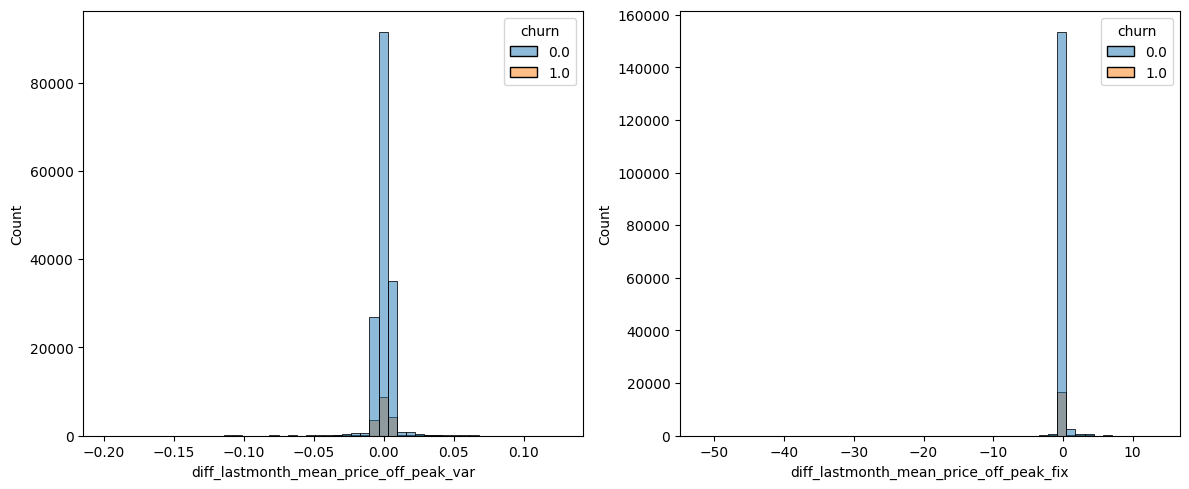

In [51]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax = ax.flatten()
for i,col in enumerate(['diff_lastmonth_mean_price_off_peak_var','diff_lastmonth_mean_price_off_peak_fix']):
    sns.histplot(data=temp2,x=temp2[col],hue='churn',bins=50,ax=ax[i])
plt.tight_layout()
plt.show()

The above plots shows that the change in prices with respect to the mean price doesn't affect churning trend, but in order to support that discovery we will need further analysis to see weather increasing prices affect churning or not.

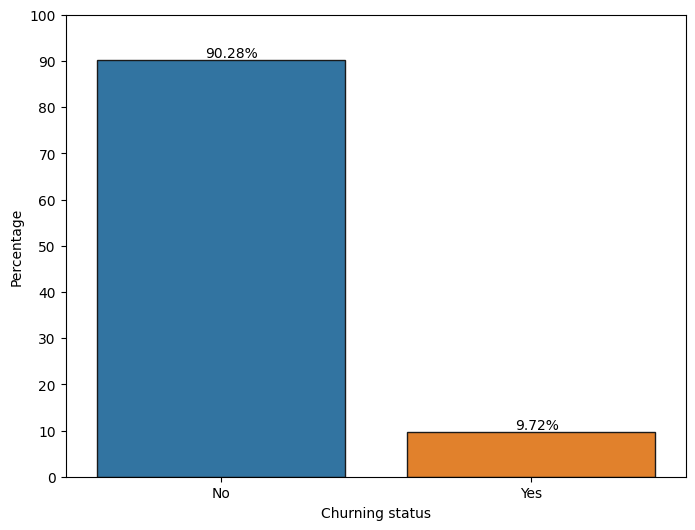

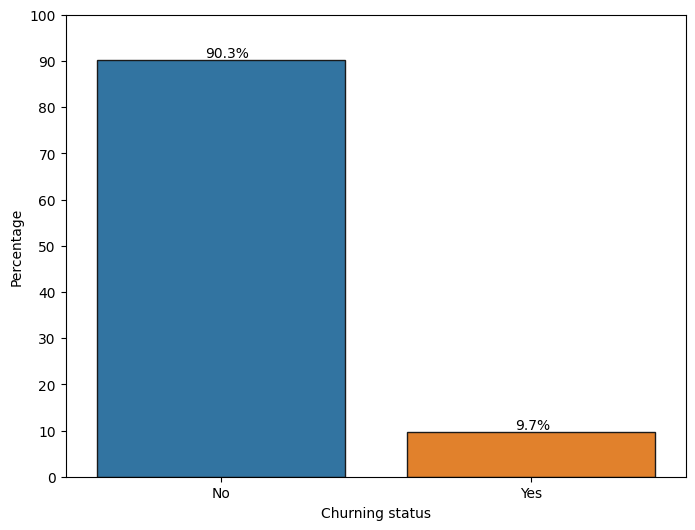

In [52]:
for dataset_ in [temp2[temp2['diff_lastmonth_mean_price_off_peak_var'] > 0],temp2[temp2['diff_lastmonth_mean_price_off_peak_var'] <= 0]]:
    ax = bar_plot_prec_above(dataset_,'churn',0.05,(8,6))
    ax.set_xlabel('Churning status')
    ax.set_ylabel('Percentage')
    ax.set_xticklabels(['No','Yes'])
    plt.show()

Churning percentage doesn't change signficantly with respect to change of price from the mean price, as the churning percentage is 9.72% for clients that their last month price increased, while for clients that their last month price decreased or stayed the same equals 9.7%.

So, as we see that changing price doesn't affect churning, but to ensure that we will by comparing the prices of last month with average of last 6 monthes and last 3 monthes instead of the whole calender year.

In [53]:
price_last_6month = price_df.copy()
price_last_6month = price_last_6month[price_last_6month['price_date'] > '2015-06-01']
price_last_6month.drop(columns=['price_date'],inplace=True)
price_last_6month = price_last_6month.groupby(['id']).agg(['mean','max','min'])
price_last_6month = rename_flatten_cols(price_last_6month)
price_last_6month.reset_index(inplace=True)
price_last_6month = price_last_6month.merge(client_df[['id','churn']],on='id',how='left')
price_last_6month.dropna(subset=['churn'],inplace=True)
temp3 = pd.DataFrame(price_df[price_df['id'].isin(price_churn_df['id'])])
temp3 = temp3.merge(price_last_6month,on='id',how='left')
offpeak_price_features = ['price_off_peak_var','price_off_peak_fix']
for feature in offpeak_price_features:
    temp3[f'diff_6month_mean_{feature}'] = temp3[f'{feature}'] - temp3[f'{feature}_mean']
temp3.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_off_peak_var_mean,price_off_peak_var_max,...,price_off_peak_fix_min,price_peak_fix_mean,price_peak_fix_max,price_peak_fix_min,price_mid_peak_fix_mean,price_mid_peak_fix_max,price_mid_peak_fix_min,churn,diff_6month_mean_price_off_peak_var,diff_6month_mean_price_off_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.146603,0.150321,...,44.44471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004764,-0.177779
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.146603,0.150321,...,44.44471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004764,-0.177779
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.146603,0.150321,...,44.44471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.004764,-0.177779
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0.146603,0.150321,...,44.44471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003023,-0.177779
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0.146603,0.150321,...,44.44471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003023,-0.177779


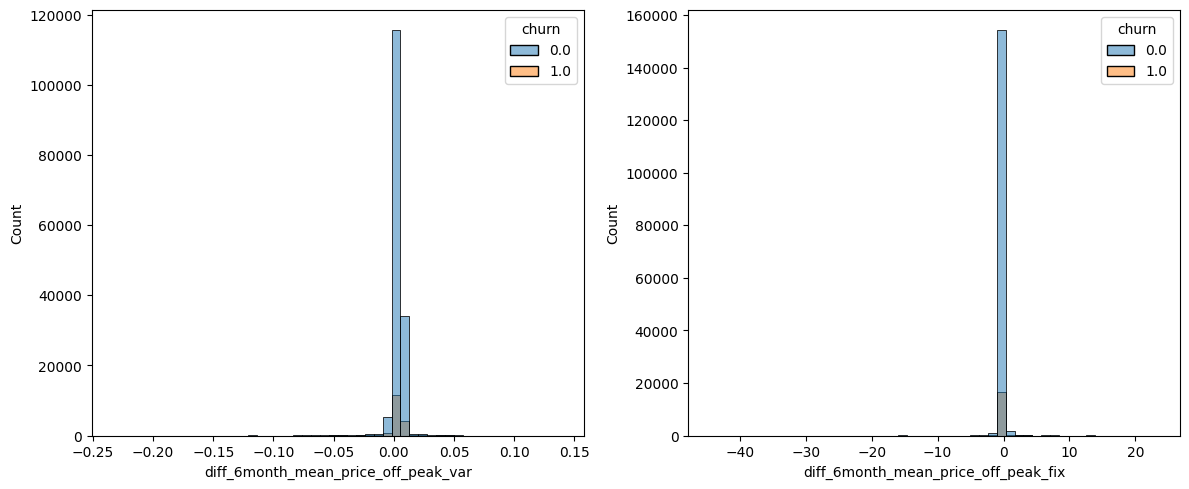

In [54]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax = ax.flatten()
for i,col in enumerate(['diff_6month_mean_price_off_peak_var','diff_6month_mean_price_off_peak_fix']):
    sns.histplot(data=temp3,x=temp3[col],hue='churn',bins=50,ax=ax[i])
plt.tight_layout()
plt.show()

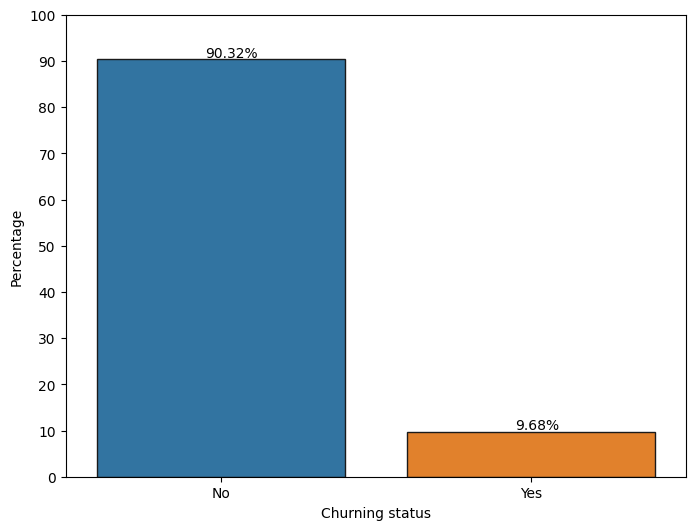

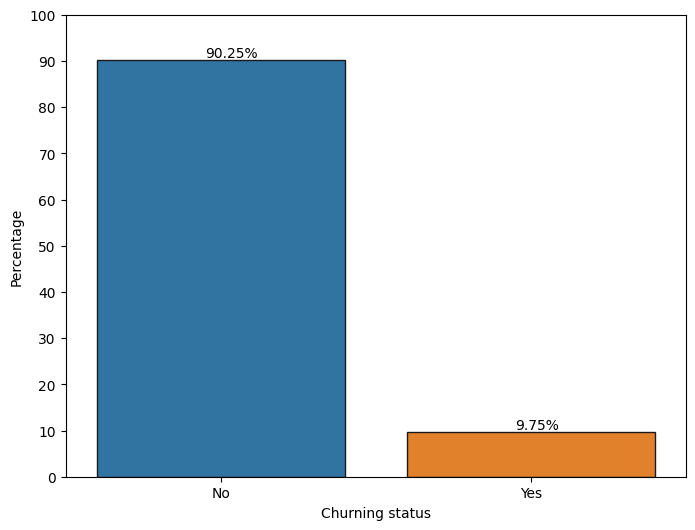

In [55]:
for dataset_ in [temp3[temp3['diff_6month_mean_price_off_peak_var'] > 0],temp3[temp3['diff_6month_mean_price_off_peak_var'] <= 0]]:
    ax = bar_plot_prec_above(dataset_,'churn',0.05,(8,6))
    ax.set_xlabel('Churning status')
    ax.set_ylabel('Percentage')
    ax.set_xticklabels(['No','Yes'])
    plt.show()

Churning percentage doesn't change signficantly with respect to change of price from the mean price of the last 6 monthes, as the churning percentage is 9.68% for clients that their last month price increased, while for clients that their last month price decreased or stayed the same equals 9.75%. <br>
So, as we see that changing price doesn't affect churning, but to ensure that we will by comparing the prices of last month with average of last 3 monthes.

In [56]:
price_last_3month = price_df.copy()
price_last_3month = price_last_3month[price_last_3month['price_date'] > '2015-09-01']
price_last_3month.drop(columns=['price_date'],inplace=True)
price_last_3month = price_last_3month.groupby(['id']).agg(['mean','max','min'])
price_last_3month = rename_flatten_cols(price_last_3month)
price_last_3month.reset_index(inplace=True)
price_last_3month = price_last_3month.merge(client_df[['id','churn']],on='id',how='left')
price_last_3month.dropna(subset=['churn'],inplace=True)
temp4 = pd.DataFrame(price_df[price_df['id'].isin(price_churn_df['id'])])
temp4 = temp4.merge(price_last_3month,on='id',how='left')
offpeak_price_features = ['price_off_peak_var','price_off_peak_fix']
for feature in offpeak_price_features:
    temp4[f'diff_3month_mean_{feature}'] = temp4[f'{feature}'] - temp4[f'{feature}_mean']
temp4.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_off_peak_var_mean,price_off_peak_var_max,...,price_off_peak_fix_min,price_peak_fix_mean,price_peak_fix_max,price_peak_fix_min,price_mid_peak_fix_mean,price_mid_peak_fix_max,price_mid_peak_fix_min,churn,diff_3month_mean_price_off_peak_var,diff_3month_mean_price_off_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.145859,0.145859,...,44.44471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005508,-0.177779
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.145859,0.145859,...,44.44471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005508,-0.177779
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0,0.145859,0.145859,...,44.44471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005508,-0.177779
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0.145859,0.145859,...,44.44471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003767,-0.177779
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0,0.145859,0.145859,...,44.44471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003767,-0.177779


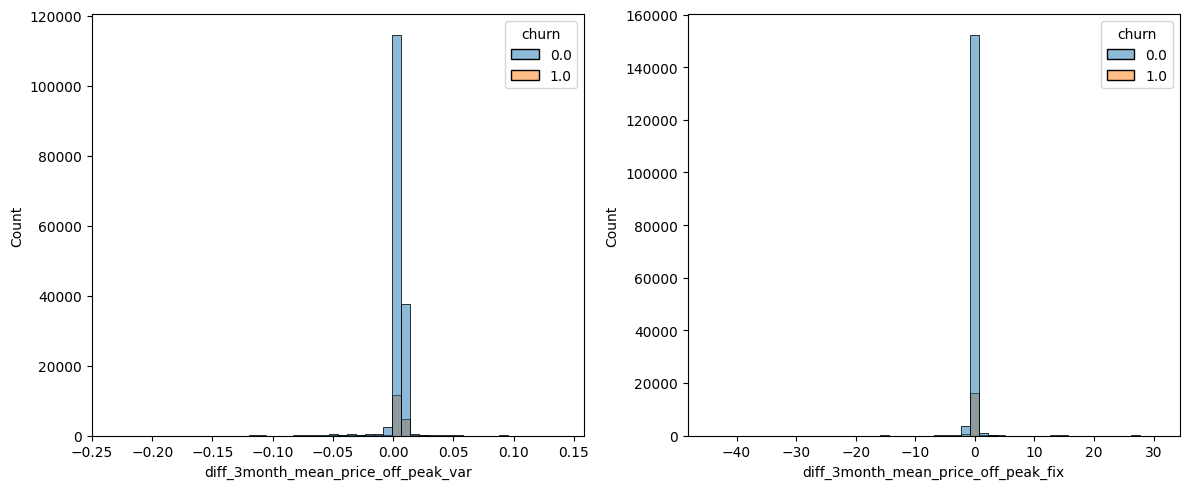

In [57]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
ax = ax.flatten()
for i,col in enumerate(['diff_3month_mean_price_off_peak_var','diff_3month_mean_price_off_peak_fix']):
    sns.histplot(data=temp4,x=temp4[col],hue='churn',bins=50,ax=ax[i])
plt.tight_layout()
plt.show()

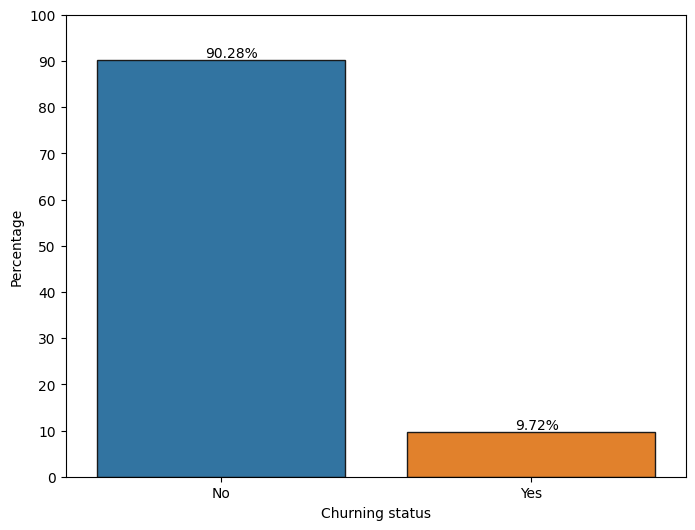

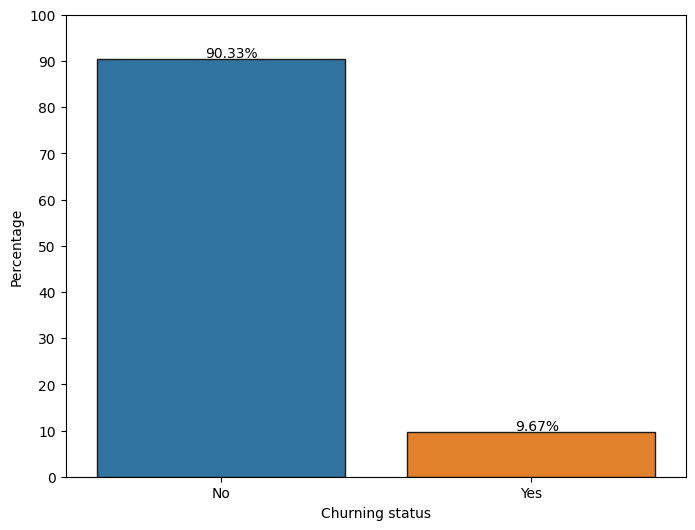

In [58]:
for dataset_ in [temp4[temp4['diff_3month_mean_price_off_peak_var'] > 0],temp4[temp4['diff_3month_mean_price_off_peak_var'] <= 0]]:
    ax = bar_plot_prec_above(dataset_,'churn',0.05,(8,6))
    ax.set_xlabel('Churning status')
    ax.set_ylabel('Percentage')
    ax.set_xticklabels(['No','Yes'])
    plt.show()

Churning percentage doesn't change signficantly with respect to change of price from the mean price of the last 3 monthes, as the churning percentage is 9.72% for clients that their last month price increased, while for clients that their last month price decreased or stayed the same equals 9.67%. <br>
**So, as we see that changing price doesn't affect churning.**

---
# Sub-Task 3
## Summary of Exploratory Data Analysis

### Key Findings: 
1. **Churning percentage** is equal **9.72%** from company's clients.
2. **Numerical features' distribution** appears to be **skewed** and have **outliers**.
3. **Customers' churning** is not sensitive to price.
### Data Augmentation suggestions: 
1. Interpret the reason why some **power prices** for clients is **Zero**, **Is it a freepower?and Why?**.
2. Gather data about **competitors' prices** to take the **prices' differences** into account while analysis.
3. Make a **satisfaction metric** from surveys about **company's service** to interpret if satisfaction is the feature that makes the clients' **doesn't churn** even when **prices increase**.

# Task 3: Feature Engineering and Modelling

# Sub-Task 1
## Feature Engineering

In [59]:
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')

In [60]:
monthly_price_by_id = price_df.groupby(['id','price_date']).agg(['mean'])
monthly_price_by_id = rename_flatten_cols(monthly_price_by_id)

In [61]:
jan_prices = monthly_price_by_id.groupby(['id']).first().reset_index()
dec_prices = monthly_price_by_id.groupby(['id']).last().reset_index()

In [62]:
attr_col = dec_prices.columns.to_list()
attr_col.remove('id')
print(attr_col)

['price_off_peak_var_mean', 'price_peak_var_mean', 'price_mid_peak_var_mean', 'price_off_peak_fix_mean', 'price_peak_fix_mean', 'price_mid_peak_fix_mean']


In [63]:
for col in attr_col:
    dec_prices.rename(columns={col:f'{col}_dec'},inplace=True)
for col in attr_col:
    jan_prices.rename(columns={col:f'{col}_jan'},inplace=True)

In [64]:
price_diff = jan_prices.merge(right=dec_prices,how='left',on='id')

In [65]:
'price_off_peak_var_mean', 'price_peak_var_mean','price_mid_peak_var_mean', 'price_off_peak_fix_mean','price_peak_fix_mean', 'price_mid_peak_fix_mean'

('price_off_peak_var_mean',
 'price_peak_var_mean',
 'price_mid_peak_var_mean',
 'price_off_peak_fix_mean',
 'price_peak_fix_mean',
 'price_mid_peak_fix_mean')

In [66]:
for col in attr_col:
    price_diff[f'{col}_jandec_diff'] = price_diff[f'{col}_dec'] - price_diff[f'{col}_jan']

In [67]:
for col in attr_col:
    price_diff.drop(columns=[f'{col}_jan'],inplace=True)
    price_diff.drop(columns=[f'{col}_dec'],inplace=True)
price_diff.head(2)

,id,price_off_peak_var_mean_jandec_diff,price_peak_var_mean_jandec_diff,price_mid_peak_var_mean_jandec_diff,price_off_peak_fix_mean_jandec_diff,price_peak_fix_mean_jandec_diff,price_mid_peak_fix_mean_jandec_diff
0,0002203ffbb812588b632b9e628cc38d,-0.006192,-0.002302,0.003487,0.162916,0.097749,0.065166
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.000000,0.000000,0.177779,0.000000,0.000000


In [68]:
train_df = client_df.merge(right=price_diff,on='id',how='left')
train_df.head(2)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,pow_max,churn,start_year,end_year,price_off_peak_var_mean_jandec_diff,price_peak_var_mean_jandec_diff,price_mid_peak_var_mean_jandec_diff,price_off_peak_fix_mean_jandec_diff,price_peak_fix_mean_jandec_diff,price_mid_peak_fix_mean_jandec_diff
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,43.648,1,2013,2016,0.020057,-0.017912,-0.071536,3.700961,-24.339581,-16.226389
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,13.800,0,2009,2016,-0.003767,0.000000,0.000000,0.177779,0.000000,0.000000


In [69]:
train_df['modif_year'] = pd.to_datetime(train_df['date_modif_prod']).dt.year
train_df['renewal_year'] = pd.to_datetime(train_df['date_renewal']).dt.year
train_df.drop(columns=['date_activ','date_end','date_modif_prod','date_renewal'],inplace=True)
train_df.head(2)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,start_year,end_year,price_off_peak_var_mean_jandec_diff,price_peak_var_mean_jandec_diff,price_mid_peak_var_mean_jandec_diff,price_off_peak_fix_mean_jandec_diff,price_peak_fix_mean_jandec_diff,price_mid_peak_fix_mean_jandec_diff,modif_year,renewal_year
0,24011ae4ebbe3035111d65fa7c15bc57,4,0,54946,0,0.00,0,0.0,1.78,0.114481,...,2013,2016,0.020057,-0.017912,-0.071536,3.700961,-24.339581,-16.226389,2015,2015
1,d29c2c54acc38ff3c0614d0a653813dd,0,4660,0,0,189.95,0,0.0,16.27,0.145711,...,2009,2016,-0.003767,0.000000,0.000000,0.177779,0.000000,0.000000,2009,2015


In [70]:
train_df['has_gas'] = LE.fit_transform(train_df['has_gas'])
LE.classes_

array(['f', 't'], dtype=object)

# Sub-Task 2
## Modelling
### Splitting data 

In [71]:
X = train_df.drop(columns=['id','churn'])
Y = train_df['churn']
print('X Shape is:',X.shape)
print('Y Shape is:',Y.shape)

X Shape is: (14606, 30)
Y Shape is: (14606,)


### Random Forest Algorithm:

In [72]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,stratify=Y)
RFC = RandomForestClassifier()
RFC.fit(X_train,Y_train)
Y_pred = RFC.predict(X_test)

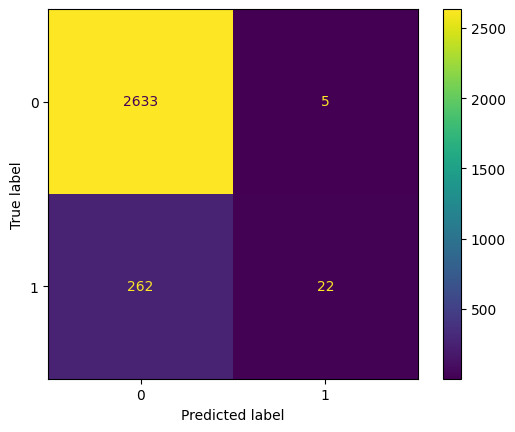

In [73]:
CMF = confusion_matrix(Y_test,Y_pred)
CMF_Display = ConfusionMatrixDisplay(CMF)
CMF_Display.plot()
plt.show()

In [74]:
print(f'precision {precision_score(Y_test,Y_pred)}, and recall {recall_score(Y_test,Y_pred)} on test set.')
print(f'F1_Score {f1_score(Y_test,Y_pred)}, and accuracy {accuracy_score(Y_test,Y_pred)} on test set.')

precision 0.8148148148148148, and recall 0.07746478873239436 on test set.
F1_Score 0.14147909967845657, and accuracy 0.9086242299794661 on test set.


## Modelling Report
#### 1. Explain the performance of the model, where did the model underperform? 
We Can see that the model performance is so bad as it failed to predict **the Churning of customers who are truly churnin**g as algorithm only predicted **4.9%** churning customers truly from all the churned customer. But on other hand, the algorithm only predict **wrong that 2 customers** will churn out of **2638 customers retained**. 
#### 2. Evaluation metrics elaboration.
**Precision** measures the fraction of predicted positive instances that are actually positive.
**Recall** measures the fraction of actual positive instances that are predicted as positive.
**F1 score** is a weighted harmonic mean of precision and recall.
**Accuracy** is the fraction of all instances that are correctly classified.
#### 3. Advantages and Disadvantages of using Random forest in this case.
##### 3.1. Advantages: 
* Improved accuracy: Random forest can often achieve higher accuracy than other machine learning algorithms on imbalanced data. This is because random forest is able to learn from both the majority and minority classes. <br>
* Robustness: Random forest is relatively robust to outliers and noise in the data. This is because each tree in the forest is trained on a different bootstrap sample of the data, which helps to reduce the impact of individual data points.<br>
* Interpretability: Random forest can be more interpretable than other machine learning algorithms, such as deep learning. This is because each tree in the forest can be visualized and explained.<br>
##### 3.2. Disadvantages: 
* Overfitting: If the number of trees in the forest is too large, the model may overfit the majority class. This can lead to poor performance on the minority class. <br>
* Computational complexity: Random forest can be computationally expensive to train, especially on large datasets. <br>
#### 4. Was the performance of the model satisfacotry?
The model's performance is unsatisfactory. Although it achieved a high accuracy, this could have been achieved by a simple model that predicts that all customers will retain. The model failed to achieve its main goal, which was to predict whether customers will churn or not. This is a serious issue, as it means that the model is not providing us with any useful insights into customer churn.

------
This was the end of the tasks of BCG virtual training, But it is obvious that the model is not preforming well and this is mainly becuase of highly imbalanced data so the training model fails predict the minority class correctly, therefore we will continue to work on special techniques to solve this issue.

## 2. Re-Sampling Dataset
### 2.1. undersampling

In [75]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler

In [76]:
RUS = RandomUnderSampler(random_state=42)
RUS.fit(X_train, Y_train)
X_train_undersampled, y_train_undersampled = RUS.fit_resample(X_train, Y_train)

In [77]:
RFC = RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=5,
                             n_estimators=15, random_state=42,min_samples_split=30)
RFC.fit(X_train_undersampled, y_train_undersampled)

RandomForestClassifier(bootstrap=False, max_depth=5, min_samples_split=30,
                       n_estimators=15, random_state=42)

In [78]:
y_pred_train = RFC.predict(X_train_undersampled)
y_pred_test = RFC.predict(X_test)
print(f'precision {precision_score(y_train_undersampled,y_pred_train)}, and recall {recall_score(y_train_undersampled,y_pred_train)} on train set.')
print(f'F1_Score {f1_score(y_train_undersampled,y_pred_train)}, and accuracy {accuracy_score(y_train_undersampled,y_pred_train)} on train set.')
print(f'ROC Area under curve {roc_auc_score(y_train_undersampled,y_pred_train)} on test set.')
print('-------------------------------------------------------------------------------------------------------------------')
print(f'precision {precision_score(Y_test,y_pred_test)}, and recall {recall_score(Y_test,y_pred_test)} on test set.')
print(f'F1_Score {f1_score(Y_test,y_pred_test)}, and accuracy {accuracy_score(Y_test,y_pred_test)} on test set.')
print(f'ROC Area under curve {roc_auc_score(Y_test,y_pred_test)} on test set.')

precision 0.7017873941674506, and recall 0.6572687224669603 on train set.
F1_Score 0.6787989080982713, and accuracy 0.6889867841409691 on train set.
ROC Area under curve 0.6889867841409691 on test set.
-------------------------------------------------------------------------------------------------------------------
precision 0.15063520871143377, and recall 0.5845070422535211 on test set.
F1_Score 0.23953823953823952, and accuracy 0.6392881587953456 on test set.
ROC Area under curve 0.6148463945156915 on test set.


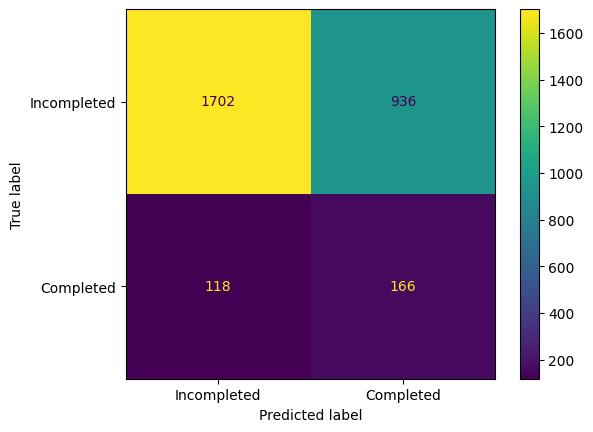

In [80]:
CMF = confusion_matrix(Y_test,y_pred_test)
CMF_Display = ConfusionMatrixDisplay(CMF)
CMF_Display.plot()
plt.xticks(ticks=[0,1],labels=['Incompleted','Completed'])
plt.yticks(ticks=[0,1],labels=['Incompleted','Completed'])
plt.show()

### 2.2. Oversampling with Stacking 

In [99]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [83]:
ROS = RandomOverSampler()
RUS.fit(X_train, Y_train)
X_train_oversampled, y_train_oversampled = ROS.fit_resample(X_train, Y_train)

In [95]:
estimators = [
     ('dt', DecisionTreeClassifier(max_depth=4,min_samples_split=10,random_state=42)),
     ('svc', SVC(C=0.5,random_state=42))]
stack_clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression(random_state=42,max_iter=200))

stack_clf.fit(X_train_oversampled, y_train_oversampled)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(max_depth=4,
                                                       min_samples_split=10,
                                                       random_state=42)),
                               ('svc', SVC(C=0.5, random_state=42))],
                   final_estimator=LogisticRegression(max_iter=200,
                                                      random_state=42))

In [96]:
y_pred_train = stack_clf.predict(X_train_oversampled)
y_pred_test = stack_clf.predict(X_test)

In [97]:
print(f'precision {precision_score(y_train_oversampled,y_pred_train)}, and recall {recall_score(y_train_oversampled,y_pred_train)} on train set.')
print(f'F1_Score {f1_score(y_train_oversampled,y_pred_train)}, and accuracy {accuracy_score(y_train_oversampled,y_pred_train)} on train set.')
print(f'ROC Area under curve {roc_auc_score(y_train_oversampled,y_pred_train)} on test set.')
print('-------------------------------------------------------------------------------------------------------------------')
print(f'precision {precision_score(Y_test,y_pred_test)}, and recall {recall_score(Y_test,y_pred_test)} on test set.')
print(f'F1_Score {f1_score(Y_test,y_pred_test)}, and accuracy {accuracy_score(Y_test,y_pred_test)} on test set.')
print(f'ROC Area under curve {roc_auc_score(Y_test,y_pred_test)} on test set.')

precision 0.6584728654554091, and recall 0.5256422409707081 on train set.
F1_Score 0.5846072746441751, and accuracy 0.6265048819793345 on train set.
ROC Area under curve 0.6265048819793346 on test set.
-------------------------------------------------------------------------------------------------------------------
precision 0.16551724137931034, and recall 0.5070422535211268 on test set.
F1_Score 0.24956672443674174, and accuracy 0.70362765229295 on test set.
ROC Area under curve 0.6159168811199266 on test set.


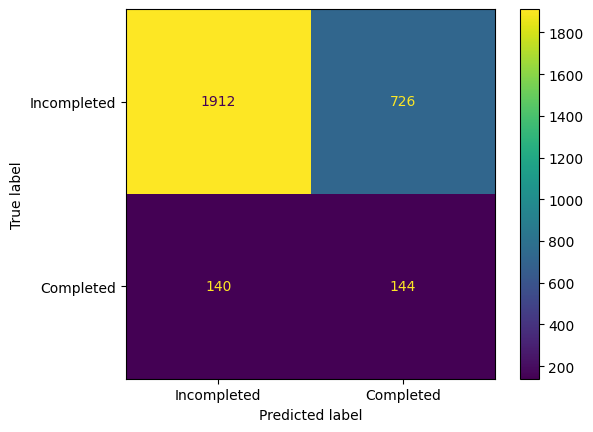

In [98]:
CMF = confusion_matrix(Y_test,y_pred_test)
CMF_Display = ConfusionMatrixDisplay(CMF)
CMF_Display.plot()
plt.xticks(ticks=[0,1],labels=['Incompleted','Completed'])
plt.yticks(ticks=[0,1],labels=['Incompleted','Completed'])
plt.show()

After Trying two methods (Undersampling then decision forest classifier) and (Oversamling with stacking classifier) and by hyperparameters tuning of each method, it was found that the first method Undersampling then decision forest classifier has a better performance as it partially solved our problem that we couldn't predict the positive class correctly, as it predicted it 166 times from about 284 times we have that class (58.45%) which is a significant increase in performance as the intial model only predicted 22 times correctly, But also there is a decrease in ability of model to predict the negative class correctly but it is acceptable for us becuase the overall performance is increasing. 

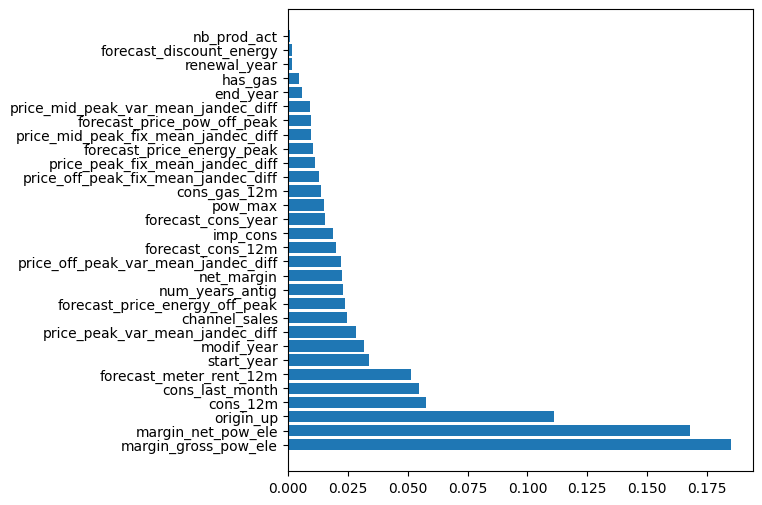

In [100]:
Importance = pd.DataFrame({"feature_names": RFC.feature_names_in_, "importances": RFC.feature_importances_}).sort_values(by='importances',ascending=False).reset_index(drop=True)
plt.figure(figsize=(6,6))
plt.barh(y=Importance['feature_names'],width=Importance['importances'])
plt.savefig(fname='importance.jpeg')
plt.show()

After undersampling of the dataset and hyperparameters tuning of decision forest classifier the model, this is the features' importances of the tuned model, we see that churning possibility is highly related to paying margin of client on electricity, their consumption for the past 12 monthes, and also high relation to what marketing campaign made the client join our company. 